In [1]:
import os, torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models._utils import IntermediateLayerGetter
import torch.nn.functional as F


In [12]:
backbone = torchvision.models.resnet34(pretrained=True)
return_layers = {'layer4': 'out'}
backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

In [16]:
image = torch.ones(1, 3, 256, 256)

In [17]:
ans = backbone(image)

In [18]:
ans['out'].shape

torch.Size([1, 512, 8, 8])

In [1]:
from Demo import ImagineNet

In [2]:
import argparse
import json
import os
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import torch
from torch import gt, nn

from torch.utils.data import DataLoader

import torch.nn.functional as F
torch.backends.cudnn.benchmark = True
import torch.distributed as dist

os.sys.path.append('/root/End2End')
os.sys.path.append('/root/End2End/v1')
from utils.trainer import Engine
from v1.config import GlobalConfig
from v1.carla_data import CARLA_Data


# Config
config = GlobalConfig()

# Data
train_set = CARLA_Data(root=config.train_data, config=config)
val_set = CARLA_Data(root=config.val_data, config=config)

dataloader_train = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=16, pin_memory=True)
dataloader_val = DataLoader(val_set, batch_size=config.batch_size, shuffle=True, num_workers=16, pin_memory=True)

# Model
model = ImagineNet(config)
model = nn.DataParallel(model, device_ids=config.multi_gpus).cuda()
# model.to('cuda:0')
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
trainer = Engine(model, dataloader_train, dataloader_val, optimizer, '/root/End2End/v1/log')

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ('Total trainable parameters: ', params)


# Load checkpoint
if isinstance(model, nn.DataParallel):
      model.module.load_state_dict(torch.load(os.path.join('/root/End2End/v1/log/ImagineNet', 'best_model.pth')))
else :
      model.load_state_dict(torch.load(os.path.join('/root/End2End/v1/log/ImagineNet', 'best_model.pth')))

  0%|          | 0/2 [00:00<?, ?it/s]loading 5366 frames from routes_town02_tiny_10_07_10_23_15
loading 12323 frames from routes_town03_tiny_10_09_08_16_25
  0%|          | 0/2 [00:00<?, ?it/s]loading 1011 frames from routes_town02_short_10_08_06_44_10
loading 507 frames from routes_town03_short_10_08_09_20_46
100%|██████████| 2/2 [00:00<00:00, 1048.31it/s]
Total trainable parameters:  28376904


In [3]:
for i in tqdm(dataloader_val):
      data = i
      break

  0%|          | 0/95 [00:11<?, ?it/s]


In [4]:
data.keys()

dict_keys(['fronts', 'tels', 'seg_fronts', 'seg_tels', 'lefts', 'seg_lefts', 'rights', 'seg_rights', 'target_point', 'steer', 'throttle', 'brake', 'command', 'velocity', 'waypoints'])

In [4]:
data_in, label = model.module.data_preprocess(data)

In [14]:
label = label.view(-1, 256, 256)

In [11]:
import torch
with torch.no_grad():
      pred = model(data_in)

In [7]:
pred.shape

torch.Size([512, 8, 256, 256])

In [29]:
label[401].max()

tensor(5, device='cuda:0')

In [5]:
data_in.shape

torch.Size([16, 32, 3, 256, 256])

In [7]:
import matplotlib.pyplot as plt

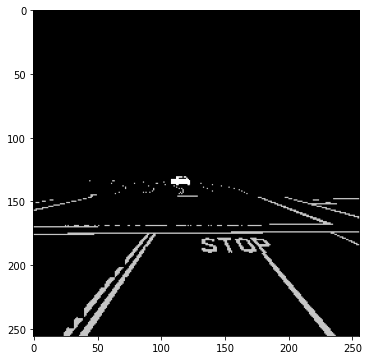

In [26]:
plt.rcParams['figure.figsize'] = (16.0, 6.0) 
# f, axarr = plt.subplots(1, 1)
# axarr[0].imshow(lefts[0,0,:,:,:].detach().cpu().permute(1, 2, 0).int(), cmap='Greys_r')
plt.imshow(label[35].cpu(), cmap='Greys_r')
#plt.imshow(data_in[0, 0,:,:,:].detach().cpu().permute(1, 2, 0).int(), cmap='Greys_r')
plt.show()

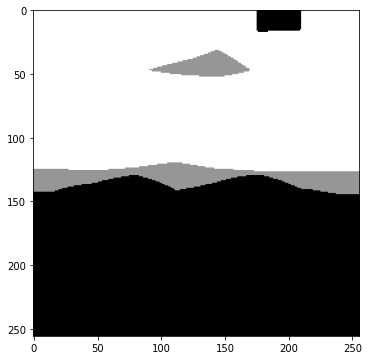

In [28]:
plt.rcParams['figure.figsize'] = (16.0, 6.0) 
# f, axarr = plt.subplots(1, 1)
# axarr[0].imshow(lefts[0,0,:,:,:].detach().cpu().permute(1, 2, 0).int(), cmap='Greys_r')
plt.imshow(pred[35].argmax(0).cpu(), cmap='Greys_r')
# axarr[2].imshow(rights[0,0,:,:,:].detach().cpu().permute(1, 2, 0).int(), cmap='Greys_r')
plt.show()

In [24]:
img = pred.cpu()

In [28]:
img = img[0]

In [30]:
img.min()

tensor(-19.1193)

In [8]:
pred[231].argmax(0).shape

torch.Size([256, 256])